In [1]:
# import functions
# version 2: did not use imputation. just ML directly 

# parameters:

import pandas as pd
import numpy as np
import codecs
import matplotlib.pyplot as plt

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
from sklearn.preprocessing import StandardScaler                 #normalising features
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.svm import SVC, SVR

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sknn import mlp

from scipy.optimize import minimize

import theano
import theano.tensor as T

%matplotlib inline

np.random.seed=10


Using Theano backend.
C:\Users\Yanjie\Anaconda\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
import matplotlib.pyplot as plt

from py4j.java_gateway import JavaGateway

In [3]:
%matplotlib inline

# set up connection

In [4]:
gw = JavaGateway() # New gateway connection
bridge = gw.entry_point

# load netlogo model

In [5]:
# Path to the model:
models_path = "D:/Work/PhD/Github/NetLogoModel/"
model_name = "PhD_InitialModelV2.nlogo"

In [6]:
modelLocation = models_path + model_name

In [7]:
modelLocation

'D:/Work/PhD/Github/NetLogoModel/PhD_InitialModelV2.nlogo'

In [8]:
bridge.openModel(modelLocation)

# Run one iteration of the model, one command at a time:

In [ ]:
bridge.command("set grid-size 21")
bridge.command("set nb-people 1")
bridge.command("set Show_Names_Nodes? False")
bridge.command("set Show_Names_people? False")
bridge.command("set car-speed 1")
bridge.command("set mobiletowerdata? True")
bridge.command("set socialmedia_data? True")
bridge.command("set grids_covered_vector 5")
bridge.command("set avg_num_calls_perday 10")
bridge.command("set avg_call_duration_mins 2")

bridge.command("random-seed 0")
bridge.command("setup")
bridge.command("repeat 144000 [go]")

In [ ]:
bridge.command("repeat 144000 [go]")

# Have the model report results

In [9]:
!head -n 15 ./agentdata.txt

 0 0 0 441 15 0 30 -37 453
 1 0 1 441 15 0 30 -37 453
 2 0 2 441 15 0 30 -37 453
 3 0 3 441 15 0 30 -37 453
 4 0 4 441 15 0 30 -37 453
 5 0 5 441 15 0 30 -37 453
 6 0 6 441 15 0 30 -37 453
 7 0 7 441 15 0 30 -37 453
 8 0 8 441 15 0 30 -37 453
 9 0 9 441 15 0 30 -37 453
 10 0 10 441 15 0 30 -37 453
 11 0 11 441 15 0 30 -37 453
 12 0 12 441 15 0 30 -37 453
 13 0 13 441 15 0 30 -37 453
 14 0 14 441 15 0 30 -37 453


In [10]:
!head -n 15 ./mobiletowers.txt

 406 0 406 441 0 15 9.523809523809524 453 32 -32
 423 0 423 441 0 15 9.523809523809524 453 32 -32
 543 0 543 441 0 15 9.523809523809524 451 16 0
 592 0 592 441 0 25 9.523809523809524 470 -32 16
 605 0 605 441 0 25 9.523809523809524 470 -32 16
 667 0 667 441 0 25 9.523809523809524 470 -32 16
 731 0 731 441 0 25 9.523809523809524 470 -32 16
 798 0 798 441 0 35 9.523809523809524 460 16 16
 1263 0 1263 441 0 15 9.523809523809524 453 32 -32
 1562 1 122 441 0 15 9.523809523809524 453 32 -32
 1799 1 359 441 0 15 9.523809523809524 453 32 -32
 2295 1 855 441 0 35 9.523809523809524 460 16 16
 2380 1 940 441 0 25 9.523809523809524 470 -32 16
 2419 1 979 441 0 25 9.523809523809524 470 -32 16
 2572 1 1132 441 0 15 9.523809523809524 457 0 -16


In [28]:
# initiating the netlogo model
# and run it for the first 10 days
def model_init():
    bridge.command("set grid-size 21")
    bridge.command("set nb-people 1")
    bridge.command("set Show_Names_Nodes? False")
    bridge.command("set Show_Names_people? False")
    bridge.command("set car-speed 1")
    bridge.command("set mobiletowerdata? True")
    bridge.command("set socialmedia_data? True")
    bridge.command("set grids_covered_vector 5")
    bridge.command("set avg_num_calls_perday 10")
    bridge.command("set avg_call_duration_mins 2")
    bridge.command("random-seed 0")
    bridge.command("setup")
    bridge.command("repeat 14400 [go]")


In [26]:
# import simuated data
# using function as the file can be closed automatically
def rawimport(path, columnname):
    agentdata = pd.read_csv(path, delimiter=' ', header=None, names=columnname)
    agentdata = agentdata.drop(labels="todrop", axis=1)
    return agentdata


In [27]:
# run NL model; 
def run_NL(mob_call):
    bridge.command(mob_call)


In [13]:
def data_input(last_n):
    path = './agentdata.txt'
    columnname = ["todrop", "acc_time", "day", "minute", "pid", "zone", "status", "xcor", "ycor", "tid"]
    agentdata = rawimport(path, columnname)

    path = './mobiletowers.txt'
    columnname = ["todrop", "acc_time", "day", "minute", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
    mobiledata = rawimport(path, columnname)
    # leave the last n day(s) out for testing purpose

    mobiledata_ML = mobiledata[mobiledata['day'] <= (mobiledata['day'].max() - last_n)]
    mobiledata_ML = mobiledata.drop('radius', axis = 1)
    mobiledata_ML.drop('tid', axis=1, inplace=True)
    mobiledata_ML.drop('txcor', axis=1, inplace=True)
    mobiledata_ML.drop('tycor', axis=1, inplace=True)
    
    return (agentdata, mobiledata_ML)


In [14]:
class ReturnedValue(object):
    def __init__(self, clf1, clf2, clf3, clf4):
        self.clf1 = clf1
        self.clf2 = clf2
        self.clf3 = clf3
        self.clf4 = clf4


In [15]:
def NL_ML(mobiledata_ML):
    # prepare for ML
    X = mobiledata_ML.drop('tzone', axis=1)
    y = mobiledata_ML['tzone']
    trainX, testX, trainY, testY = train_test_split(X, y)
    # knn
    clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
    pred_knn = clf_knn.predict(testX)
    #print roc_auc_score(testY, pred_knn)
    AC_knn = accuracy_score(testY, pred_knn)
    RC_knn = recall_score(testY, pred_knn, average=None).mean() 
    CF_knn = confusion_matrix(testY, pred_knn)
    CV_knn = cross_val_score(clf_knn, X, y, cv=3)
    ## using ridge regression
    clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
    pred_rdg = clf_rdg.predict(testX)
    AC_rdg = accuracy_score(testY, pred_rdg)
    RC_rdg = recall_score(testY, pred_rdg, average=None).mean()  
    CF_rdg =  confusion_matrix(testY, pred_rdg)
    CV_rdg = cross_val_score(clf_rdg, X, y, cv=3)
    ## using RF
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
    clf_rf.fit(trainX, trainY)
    pred_rf = clf_rf.predict(testX)
    AC_rf = accuracy_score(testY, pred_rf)
    RC_rf = recall_score(testY, pred_rf, average=None).mean()   
    CF_rf = confusion_matrix(testY, pred_rf)
    CV_rf = cross_val_score(clf_rf, X, y, cv=3)
    ## using GBDT
    clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
    clf_gb.fit(trainX, trainY)
    pred_gb = clf_gb.predict(testX)
    AC_gb = accuracy_score(testY, pred_gb)
    RC_gb = recall_score(testY, pred_gb, average=None).mean()  
    CF_gb = confusion_matrix(testY, pred_gb)
    CV_gb = cross_val_score(clf_gb, X, y, cv=3)
    
    trained_clf = ReturnedValue(clf_knn, clf_rdg, clf_rf, clf_gb)
    trained_CV = ReturnedValue(CV_knn, CV_rdg, CV_rf, CV_gb)
    trained_RC = ReturnedValue(RC_knn, RC_rdg, RC_rf, RC_gb)
    trained_CM = ReturnedValue(CF_knn, CF_rdg, CF_rf, CF_gb)
    trained_AC = ReturnedValue(AC_knn, AC_rdg, AC_rf, AC_gb)
    
    return (trained_clf, trained_CV, trained_RC, trained_CM, trained_AC)

In [16]:
def pred_agent(trained_clf, agentdata, last_n):
    last_minutes = last_n * (-1440)
    pred_X = agentdata[last_minutes:].iloc[:,0:4]
    pred_X['tpid'] = 0
    pred_y = agentdata[last_minutes:].iloc[:,4]

    pred_knn = trained_clf.clf1.predict(pred_X)
    #print roc_auc_score(testY, pred_knn)
    knn_AC = accuracy_score(pred_y, pred_knn)
    knn_RC = recall_score(pred_y, pred_knn, average='macro')
    knn_CM = confusion_matrix(pred_y, pred_knn)

    ## using ridge regression
    pred_rdg = trained_clf.clf2.predict(pred_X)
    rdg_AC = accuracy_score(pred_y, pred_rdg)
    rdg_RC = recall_score(pred_y, pred_rdg, average='macro')  
    rdg_CM = confusion_matrix(pred_y, pred_rdg)

    ## using RF
    pred_rf = trained_clf.clf3.predict(pred_X)
    rf_AC = accuracy_score(pred_y, pred_rf)
    rf_RC = recall_score(pred_y, pred_rf, average='macro')  
    rf_CM = confusion_matrix(pred_y, pred_rf)

    ## using GBDT
    pred_gb = trained_clf.clf4.predict(pred_X)
    gb_AC = accuracy_score(pred_y, pred_gb)
    gb_RC = recall_score(pred_y, pred_gb, average='macro')  
    gb_CM = confusion_matrix(pred_y, pred_gb)
    
    pr_RC = ReturnedValue(knn_RC, rdg_RC, rf_RC, gb_RC)
    pr_CM = ReturnedValue(knn_CM, rdg_CM, rf_CM, gb_CM)
    pr_AC = ReturnedValue(knn_AC, rdg_AC, rf_AC, gb_AC)

    return (pr_RC, pr_CM, pr_AC)


In [17]:
## run Netlogo and carryout ML
knn_all_RC = []
rdg_all_RC = []
rf_all_RC = []
gb_all_RC = []

knn_all_CM = []
rdg_all_CM = []
rf_all_CM = []
gb_all_CM = []

knn_all_AC = []
rdg_all_AC = []
rf_all_AC = []
gb_all_AC = []

knn_all_cv_tr = []
rdg_all_cv_tr = []
rf_all_cv_tr = []
gb_all_cv_tr = []

knn_all_RC_tr = []
rdg_all_RC_tr = []
rf_all_RC_tr = []
gb_all_RC_tr = []

knn_all_AC_tr = []
rdg_all_AC_tr = []
rf_all_AC_tr = []
gb_all_AC_tr = []

agentdata_tot = {}
mobiledata_tot = {}

last_n = 1 # define the number of days to be left out from simulation data for testing purpose
num_sim = 14400 # define the duration of simulation (in minutes)

model_init()

for x in range(7200, 216000, 1440):
    print x
    mob_call = "repeat " + str(x) + " [go]" 
    run_NL(mob_call)
    agentdata, mobiledata_ML = data_input(last_n)
    train_clf, train_CV, train_RC, train_CM, train_AC = NL_ML(mobiledata_ML)
    pred_RC, pred_CM, pred_AC = pred_agent(train_clf, agentdata, last_n)
    
    agentdata_tot[x] = agentdata
    mobiledata_tot[x] = mobiledata_ML
    
    knn_all_RC.append(pred_RC.clf1)
    rdg_all_RC.append(pred_RC.clf2)
    rf_all_RC.append(pred_RC.clf3)
    gb_all_RC.append(pred_RC.clf4)
    knn_all_CM.append(pred_CM.clf1)
    rdg_all_CM.append(pred_CM.clf2)
    rf_all_CM.append(pred_CM.clf3)
    gb_all_CM.append(pred_CM.clf4)
    knn_all_AC.append(pred_AC.clf1)
    rdg_all_AC.append(pred_AC.clf2)
    rf_all_AC.append(pred_AC.clf3)
    gb_all_AC.append(pred_AC.clf4)
    
    knn_all_cv_tr.append(train_CV.clf1)
    rdg_all_cv_tr.append(train_CV.clf2)
    rf_all_cv_tr.append(train_CV.clf3)
    gb_all_cv_tr.append(train_CV.clf4)
    knn_all_RC_tr.append(train_RC.clf1)
    rdg_all_RC_tr.append(train_RC.clf2)
    rf_all_RC_tr.append(train_RC.clf3)
    gb_all_RC_tr.append(train_RC.clf4)
    knn_all_AC_tr.append(train_AC.clf1)
    rdg_all_AC_tr.append(train_AC.clf2)
    rf_all_AC_tr.append(train_AC.clf3)
    gb_all_AC_tr.append(train_AC.clf4)

7200
14400

C:\Users\Yanjie\Anaconda\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
C:\Users\Yanjie\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



21600
28800
36000
43200
50400
57600
64800
72000
79200
86400
93600
100800
108000
115200
122400
129600
136800
144000
151200
158400
165600
172800
180000
187200
194400
201600
208800


C:\Users\Yanjie\Anaconda\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


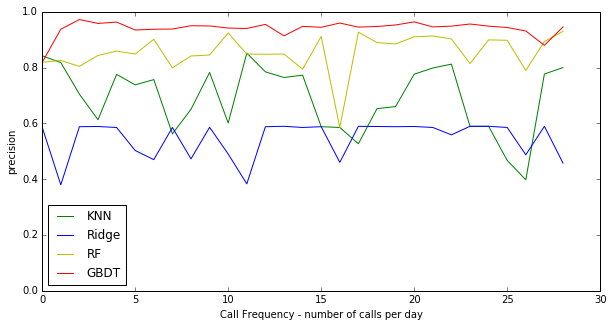

In [19]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_AC, label='KNN', color="g")
ax.plot(rdg_all_AC, label='Ridge', color="b")
ax.plot(rf_all_AC, label='RF', color="y")
ax.plot(gb_all_AC, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("precision")
ax.set_xlabel("Call Frequency - number of calls per day")
#ax.set_xticklabels(range(1,10))
ax.legend(loc='best')

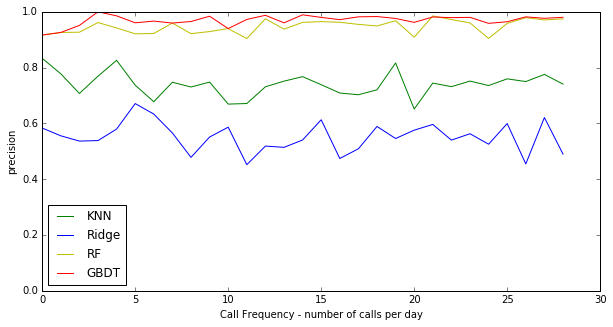

In [22]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_AC_tr, label='KNN', color="g")
ax.plot(rdg_all_AC_tr, label='Ridge', color="b")
ax.plot(rf_all_AC_tr, label='RF', color="y")
ax.plot(gb_all_AC_tr, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("precision")
ax.set_xlabel("Call Frequency - number of calls per day")
#ax.set_xticklabels(range(1,10))
ax.legend(loc='best')

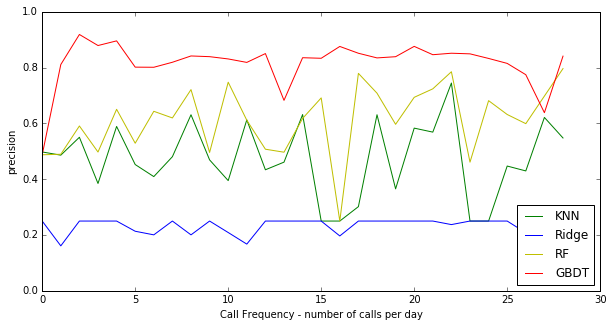

In [21]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_RC, label='KNN', color="g")
ax.plot(rdg_all_RC, label='Ridge', color="b")
ax.plot(rf_all_RC, label='RF', color="y")
ax.plot(gb_all_RC, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("precision")
ax.set_xlabel("Call Frequency - number of calls per day")
#ax.set_xticklabels(range(1,10))
ax.legend(loc='best')

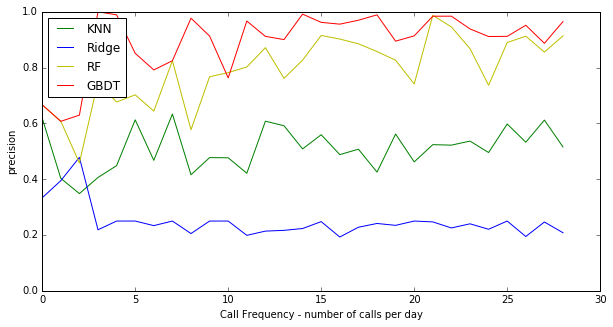

In [20]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_RC_tr, label='KNN', color="g")
ax.plot(rdg_all_RC_tr, label='Ridge', color="b")
ax.plot(rf_all_RC_tr, label='RF', color="y")
ax.plot(gb_all_RC_tr, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("precision")
ax.set_xlabel("Call Frequency - number of calls per day")
#ax.set_xticklabels(range(1,10))
ax.legend(loc='best')

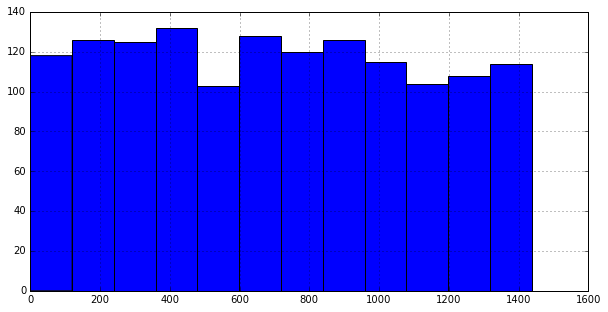

In [23]:
# checking the distribution of mobile phone calls
fig2 = plt.figure(figsize=(10,5))
ax = fig2.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
(mobiledata_ML['minute'][pd.notnull(mobiledata_ML['tzone'])]).hist(bins=12)
#plt.hist(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], bins=50)

In [24]:
mobiledata_tot

{7200:     acc_time  day  minute  pid  tpid  tzone
 0        406    0     406  441     0     15
 1        423    0     423  441     0     15
 2        543    0     543  441     0     15
 3        592    0     592  441     0     25
 4        605    0     605  441     0     25
 5        667    0     667  441     0     25
 6        731    0     731  441     0     25
 7        798    0     798  441     0     35
 8       1263    0    1263  441     0     15
 9       1562    1     122  441     0     15
 10      1799    1     359  441     0     15
 11      2295    1     855  441     0     35
 12      2380    1     940  441     0     25
 13      2419    1     979  441     0     25
 14      2572    1    1132  441     0     15
 15      2827    1    1387  441     0     15
 16      2832    1    1392  441     0     15
 17      2845    1    1405  441     0     15
 18      2942    2      62  441     0     15
 19      2983    2     103  441     0     15
 20      3059    2     179  441     0     15
 21 

In [ ]:
class User(object):
    def __init__(self, name, email):
        self.name = name
        self.email = email
    def commit(self):
        pass

jason = User('jason', 'jason@email.com')
jack = User('jack', 'jack@yahoo.com')

In [ ]:
jack.name

In [ ]:
path = './agentdata.txt'
columnname = ["todrop", "acc_time", "day", "minute", "pid", "zone", "status", "xcor", "ycor", "tid"]
agentdata = rawimport(path, columnname)

path = './mobiletowers.txt'
columnname = ["todrop", "acc_time", "day", "minute", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
mobiledata = rawimport(path, columnname)



In [ ]:
# leave the last n day(s) out for testing purpose

mobiledata_ML = mobiledata[mobiledata['day'] <= (mobiledata['day'].max() - last_n)]
mobiledata_ML = mobiledata.drop('radius', axis = 1)
mobiledata_ML.drop('tid', axis=1, inplace=True)
mobiledata_ML.drop('txcor', axis=1, inplace=True)
mobiledata_ML.drop('tycor', axis=1, inplace=True)

In [ ]:
# prepare for ML
X = mobiledata_ML.drop('tzone', axis=1)
y = mobiledata_ML['tzone']
trainX, testX, trainY, testY = train_test_split(X, y)

In [ ]:
#k fold cross-validation
from sklearn.cross_validation import KFold

for train_indices, test_indices in KFold(len(X), n_folds=3):
    fold_trainX = X.iloc[train_indices, :]
    fold_testX  = X.iloc[test_indices, :]
    fold_trainY = y[train_indices]
    fold_testY  = y[test_indices]
    clf_knn = KNeighborsClassifier(n_neighbors=2).fit(fold_trainX, fold_trainY)
    pred_knn = clf_knn.predict(fold_testX)
    #print roc_auc_score(testY, pred_knn)
    print precision_score(fold_testY, pred_knn, average='micro')  
    print recall_score(fold_testY, pred_knn, average='micro')
    confusion_matrix(fold_testY, pred_knn)
    #print fold_trainY



In [ ]:


# knn
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average=None)
print accuracy_score(testY, pred_knn)
print recall_score(testY, pred_knn, average='macro')
print recall_score(testY, pred_knn, average='micro')
print confusion_matrix(testY, pred_knn)
cross_val_score(clf_knn, X, y, cv=3)

In [ ]:
## using ridge regression
clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
pred_rdg = clf_rdg.predict(testX)
print precision_score(testY, pred_rdg, average='micro')  
print confusion_matrix(testY, pred_rdg)
cross_val_score(clf_rdg, X, y, cv=3)

In [ ]:
## using RF
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=100)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
print precision_score(testY, pred_rf, average='micro')  
print confusion_matrix(testY, pred_rf)
cross_val_score(clf_rf, X, y, cv=3)

In [ ]:
## using GBDT
clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
clf_gb.fit(trainX, trainY)
pred_gb = clf_gb.predict(testX)
print precision_score(testY, pred_gb, average='micro')  
print confusion_matrix(testY, pred_gb)
cross_val_score(clf_gb, X, y, cv=3)
#test_qualities = []
# for p in clf_gb.staged_predict_proba(testX):
#     test_qualities.append(precision_score(testY, p[:, 1]))
# plt.plot(test_qualities)

In [ ]:
## using SVM
## solving multi-classification problem?
clf_svc = SVC()
clf_svc.fit(trainX, trainY)
pred_svc = clf_svc.predict(testX)
print precision_score(testY, pred_svc, average='micro')  
print confusion_matrix(testY, pred_svc)
cross_val_score(clf_svc, X, y, cv=3)


In [ ]:
## prediction
# pre_agent1 = mobiledata[:1]
# pre_agent = pd.concat([pre_agent1]*1440)
# pre_agent['day']=mobiledata['day'].max()+1
# pre_agent['minute']=range(0,1440)
# pre_agent['acc_time']=pre_agent['minute'] + pre_agent['day']*1440
# pre_agent.drop('tzone', axis=1, inplace=True)
# pre_agent.drop('radius', axis=1, inplace=True)
# pre_agent.drop('tid', axis=1, inplace=True)
# pre_agent.drop('txcor', axis=1, inplace=True)
# pre_agent.drop('tycor', axis=1, inplace=True)
pred_X = agentdata[-1440:].iloc[:,0:4]
pred_X['tpid'] = 0
pred_y = agentdata[-1440:].iloc[:,4]


In [ ]:

pred_knn = clf_knn.predict(pred_X)
#print roc_auc_score(testY, pred_knn)
knn_PR = precision_score(pred_y, pred_knn, average='micro')
knn_CM = confusion_matrix(pred_y, pred_knn)

## using ridge regression
pred_rdg = clf_rdg.predict(pred_X)
rdg_PR = precision_score(pred_y, pred_rdg, average='micro')  
rdg_CM = confusion_matrix(pred_y, pred_rdg)

## using RF
pred_rf = clf_rf.predict(pred_X)
rf_PR = precision_score(pred_y, pred_rf, average='micro')  
rf_CM = confusion_matrix(pred_y, pred_rf)

## using GBDT
pred_gb = clf_gb.predict(pred_X)
gb_PR = precision_score(pred_y, pred_gb, average='micro')  
gb_CM = confusion_matrix(pred_y, pred_gb)

print knn_PR, rdg_PR, rf_PR, gb_PR


In [ ]:
pred_gb






In [ ]:
pre_agent

In [ ]:
# prepare for ML
X = mobiledata_fs_filled.drop('zone', axis=1)
y = mobiledata_fs_filled['zone']
trainX, testX, trainY, testY = train_test_split(X, y)

## using KNN
# weights might need to be changed - more weights towards the recent data?
# metrics? canberra, minkowski
clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
knn_PR = precision_score(testY, pred_knn, average='micro')
knn_CM = confusion_matrix(testY, pred_knn)

## using ridge regression
clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
pred_rdg = clf_rdg.predict(testX)
rdg_PR = precision_score(testY, pred_rdg, average='micro')  
rdg_CM = confusion_matrix(testY, pred_rdg)

## using RF
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
rf_PR = precision_score(testY, pred_rf, average='micro')  
rf_CM = confusion_matrix(testY, pred_rf)

## using GBDT
clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
clf_gb.fit(trainX, trainY)
pred_gb = clf_gb.predict(testX)
gb_PR = precision_score(testY, pred_gb, average='micro')  
gb_CM = confusion_matrix(testY, pred_gb)

In [ ]:
#class ReturnValue(object):
#    def __init__(self, y0, y1):
#        self.y0 = y0
#        self.y1 = y1

def data_input():
    path = './agentdata.txt'
    columnname = ["todrop", "acc_time", "day", "minute", "pid", "zone", "status", "xcor", "ycor", "tid"]
    agentdata = rawimport(path, columnname)
    
    path = './mobiletowers.txt'
    columnname = ["todrop", "acc_time", "day", "minute", "pid", "tpid", "tzone", "radius", "tid", "txcor", "tycor"]
    mobiledata = rawimport(path, columnname)
    
    # extend data to full (missing data shown as NaN)
    mobiledata = mobiledata.drop(labels = ["tid"], axis=1)

    mobiledata_fs = pd.merge(agentdata, mobiledata, how = 'left', on = ["acc_time", 'day', 'minute', "pid"])
    #mobiledata_fs = pd.merge(agentdata_ri, mobiledata_ri, how = 'left', left_index = True, right_index = True)
    #print mobiledata_fs.count()
    #mobiledata_fs
# fill the missing data using NN (k=1)
# the reason why "day" and "minute" need to be removed before imputation is that the imputation is done based on features.
# in other words, the day and minute will have impacts on the imputed results
# to maintain a continuity of a user between days it is necessary to remove "day" and "minute" before imputation and add them back later
# also no need to imputate tower id
    mobiledata_fs_test = mobiledata_fs.drop(labels = ["day"], axis=1)
    mobiledata_fs_test = mobiledata_fs_test.drop(labels = ["minute"], axis=1)
    mobiledata_fs_test = mobiledata_fs_test.drop(labels = ["tid"], axis=1)
    mobiledata_fs_filled = KNN(k=1).complete(mobiledata_fs_test)
    mobiledata_fs_filled = pd.DataFrame(mobiledata_fs_filled, columns = ["acc_time", "pid", "zone", 
                                                                     "status", "xcor", "ycor", "tpid", "tzone", 
                                                                     "radius", "txcor", "tycor"])
# add the day and minute information back
    mobiledata_daymin = mobiledata_fs.ix[:,[0, 1, 2, 3, 8]]
    mobiledata_fs_filled = pd.merge(mobiledata_daymin, mobiledata_fs_filled, how = 'left', on = ["acc_time", "pid"])
    mobiledata_cp = pd.merge(mobiledata_fs, mobiledata_fs_filled, how = 'left', on = ["acc_time", 'day', 'minute', "pid"])
    mobiledata_fs_filled.fillna(-1, inplace=True)
    
    return (mobiledata_fs, mobiledata_fs_filled, mobiledata_cp)

In [ ]:
#run_NL()

mobiledata_fs, mobiledata_fs_filled, mobiledata_cp = data_input()
#miss_imput()

In [ ]:
print mobiledata_fs_filled.count()

In [ ]:
mobiledata_fs_filled.zone.max()


In [ ]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
mobiledata_sel = mobiledata_cp[mobiledata_cp['day'] == 0]
ax1.scatter(mobiledata_sel['minute'], mobiledata_sel['tzone_x'])
ax1.set_xticks(range(0, 1440, 200))
ax1.set_yticks(range(0, 45, 15))
ax2.plot(mobiledata_sel['minute'], mobiledata_sel['tzone_y'])
ax2.set_xticks(range(0, 1440, 200))
ax2.set_yticks(range(0, 45, 15))

In [ ]:
# checking the distribution of mobile phone calls
fig2 = plt.figure(figsize=(10,5))
ax = fig2.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])]).hist(bins=12)
#plt.hist(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], bins=50)

In [ ]:
# ML
def NL_ML(mobiledata_fs_filled):
    # prepare for ML
    X = mobiledata_fs_filled.drop('zone', axis=1)
    y = mobiledata_fs_filled['zone']
    trainX, testX, trainY, testY = train_test_split(X, y)
    
    ## using KNN
    # weights might need to be changed - more weights towards the recent data?
    # metrics? canberra, minkowski
    clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
    pred_knn = clf_knn.predict(testX)
    #print roc_auc_score(testY, pred_knn)
    knn_PR = precision_score(testY, pred_knn, average='micro')
    knn_CM = confusion_matrix(testY, pred_knn)
    
    ## using ridge regression
    clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
    pred_rdg = clf_rdg.predict(testX)
    rdg_PR = precision_score(testY, pred_rdg, average='micro')  
    rdg_CM = confusion_matrix(testY, pred_rdg)
    
    ## using RF
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
    clf_rf.fit(trainX, trainY)
    pred_rf = clf_rf.predict(testX)
    rf_PR = precision_score(testY, pred_rf, average='micro')  
    rf_CM = confusion_matrix(testY, pred_rf)
    
    ## using GBDT
    clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
    clf_gb.fit(trainX, trainY)
    pred_gb = clf_gb.predict(testX)
    gb_PR = precision_score(testY, pred_gb, average='micro')  
    gb_CM = confusion_matrix(testY, pred_gb)
    
    return (knn_PR, knn_CM, rdg_PR, rdg_CM, rf_PR, rf_CM, gb_PR, gb_CM)

In [ ]:
fig3 = plt.figure(figsize=(10,5))
ax = fig3.add_subplot(1, 1, 1)
#ax.plot(mobiledata_fs['minute'][pd.notnull(mobiledata_fs['tzone'])], 'k.')
#ax.plot(pd.notnull(mobiledata_fs['tzone']), 'k.')
#ax.set_yticks([0, 1, 2])
ax.plot(knn_all_PR, label='NN', color="g")
ax.plot(rdg_all_PR, label='Ridge', color="b")
ax.plot(rf_all_PR, label='RF', color="y")
ax.plot(gb_all_PR, label='GBDT', color="r")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("precision")
ax.set_xlabel("Call Frequency - number of calls per day")
ax.set_xticklabels(range(1,10))
ax.legend(loc='best')

In [ ]:
knn_all_PR

In [ ]:
t = NL_ML(comdata_fs_filled)

In [ ]:
print gb_all_PR


In [ ]:
print t


In [ ]:
# prepare for ML

X = mobiledata_fs_filled.drop('zone', axis=1)
y = mobiledata_fs_filled['zone']

trainX, testX, trainY, testY = train_test_split(X, y)


In [ ]:
## using KNN
# weights might need to be changed - more weights towards the recent data?
# metrics? canberra, minkowski


clf_knn = KNeighborsClassifier(n_neighbors=1).fit(trainX, trainY)
pred_knn = clf_knn.predict(testX)
#print roc_auc_score(testY, pred_knn)
print precision_score(testY, pred_knn, average='micro')  
print recall_score(testY, pred_knn, average='micro')
confusion_matrix(testY, pred_knn)

In [ ]:
pred_knn.shape

In [ ]:
testX, pred_knn

In [ ]:
## using Ridge

clf_rdg = RidgeClassifier(alpha=1).fit(trainX,trainY)
pred_rdg = clf_rdg.predict(testX)
print precision_score(testY, pred_rdg, average='micro')  
print recall_score(testY, pred_rdg, average='micro')
confusion_matrix(testY, pred_rdg)

In [ ]:
## using Lasso

clf_las = Lasso(alpha=1).fit(trainX,trainY)
pred_las = clf_las.predict(testX)
print precision_score(testY, pred_las, average='micro')  
print recall_score(testY, pred_las, average='micro')
confusion_matrix(testY, pred_las)

In [ ]:
## using RF

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_rf.fit(trainX, trainY)
pred_rf = clf_rf.predict(testX)
print precision_score(testY, pred_rf, average='micro')  
print recall_score(testY, pred_rf, average='micro')
confusion_matrix(testY, pred_rf)

In [ ]:
## using GBDT

clf_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3)
clf_gb.fit(trainX, trainY)
pred_gb = clf_gb.predict(testX)
print precision_score(testY, pred_gb, average='micro')  
print recall_score(testY, pred_gb, average='micro')
confusion_matrix(testY, pred_gb)

In [ ]:
# neural network
def fit_predict_NN(trainX, trainY, testX, activate_functions, hidden_layers):
    X_ = theano.shared(trainX, name='X')
    y_ = theano.shared(trainY, name='y')
    param = T.vector()
    dim = X.shape[1]
    
    def activation(data_, parameter):
        n_previous = 0
        dim_previous = dim
        h = data_
        for n_hidden, func in zip(hidden_layers, activate_functions):
            N = dim_previous * n_hidden
            W_ = parameter[n_previous:n_previous + N].reshape((dim_previous, n_hidden))
            h = func(h.dot(W_))
            dim_previous = n_hidden
            n_previous += N

        # output     
        v_ = parameter[n_previous:]
        output = h.dot(v_)
        n_previous = n_previous + dim_previous
        
        return T.nnet.sigmoid(output), n_previous

    p_sig = activation(X_, param)[0]
    p_bck = 1 - p_sig
    llh_ = y_.dot(T.log(p_sig)) + (1 - y_).dot(T.log(p_bck))
    loss = -llh_
    
    # optimize
    loss_function = theano.function([param], loss)
    loss_grad = theano.function([param], theano.grad(loss, param))
    result = minimize(loss_function, jac=loss_grad, x0=numpy.random.normal(size=activation(X_, param)[1]))
    optimal_params = result['x']
    
    # predict data
    data = T.matrix()
    compiled_activation = theano.function([data, param], activation(data, param)[0])
    
    return compiled_activation(testX, optimal_params)


In [ ]:
## define activation function
#sigmoid (which we used, T.nnet.sigmoid)
#leaky ReLU (defined below)
#softplus (T.nnet.softplus)

def LeakyReLU(x):
    return T.switch(x > 0, x, 0.5 * x)


In [ ]:
pred = fit_predict_NN(trainX, trainY, testX, [T.nnet.sigmoid] * 3, [20, 10, 5])
print precision_score(testY, pred, average='micro')  
print recall_score(testY, pred, average='micro')

In [ ]:
import numpy as np
import time
import theano
A = np.random.rand(1000,10000).astype(theano.config.floatX)
B = np.random.rand(10000,1000).astype(theano.config.floatX)
np_start = time.time()
AB = A.dot(B)
np_end = time.time()
X,Y = theano.tensor.matrices('XY')
mf = theano.function([X,Y],X.dot(Y))
t_start = time.time()
tAB = mf(A,B)
t_end = time.time()
print("NP time: %f[s], theano time: %f[s] (times should be close when run on CPU!)" %(
                                           np_end-np_start, t_end-t_start))
print("Result difference: %f" % (np.abs(AB-tAB).max(), ))